In [21]:
%reload_kedro

[09/20/23 14:29:57] INFO     Resolved project path as: /home/jamontanac/Documents/Procesamiento     ]8;id=749322;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=530541;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/ipython/__init__.py#139\139]8;;\
                             Imagenes y video/Fighting-Illutions.                                                  
                             To set a different path, run '%reload_kedro <project_root>'                           

[09/20/23 14:29:57] WARNING  /home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site ]8;id=949467;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=293624;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/warnings.py#109\109]8;;\
                             -packages/kedro/framework/project/__init__.py:359: UserWarning: An                    
                             error occurred while importing the                                                    
                             'Fighting-Illutions.pipelines.generate_adversarial_examples' module.                  
                             Nothing defined therein will be returned by 'find_pipelines'.                         
                                                                                                                   
                             Traceback (most recent call last):                                                    
                               File                                                                                
                             "/home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/sit                
                             e-packages/kedro/framework/project/__init__.py", line 357, in                         
                             find_pipelines                                                                        
                                 pipeline_module = importlib.import_module(pipeline_module_name)                   
                               File                                                                                
                             "/home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/imp                
                             ortlib/__init__.py", line 126, in import_module                                       
                                 return _bootstrap._gcd_import(name[level:], package, level)                       
                               File "<frozen importlib._bootstrap>", line 1050, in _gcd_import                     
                               File "<frozen importlib._bootstrap>", line 1027, in _find_and_load                  
                               File "<frozen importlib._bootstrap>", line 1006, in                                 
                             _find_and_load_unlocked                                                               
                               File "<frozen importlib._bootstrap>", line 688, in _load_unlocked                   
                               File "<frozen importlib._bootstrap_external>", line 883, in                         
                             exec_module                                                                           
                               File "<frozen importlib._bootstrap>", line 241, in                                  
                             _call_with_frames_removed                                                             
                               File "/home/jamontanac/Documents/Procesamiento Imagenes y                           
                             video/Fighting-Illutions/src/Fighting-Illutions/pipelines/generate_adv                
                             ersarial_examples/__init__.py", line 6, in <module>                                   
                                 from .pipeline import create_pipeline                                             
                               File "/home/jamontanac/Documents/Procesamiento Imagenes y                           
                             video/Fighting-Illutions/src/Fighting-Illutions/pipelines/generate_adv                
                             ersarial_examples/pipeline.py", line 17, in <module>                                  
                                 parameters = conf_loader["parameters"

[09/20/23 14:29:58] INFO     Kedro project Fighting Illutions                                       ]8;id=655435;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=438629;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/ipython/__init__.py#108\108]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=999127;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=215122;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/ipython/__init__.py#109\109]8;;\
                             'pipelines'                                                                           

                    INFO     Registered line magic 'run_viz'                                        ]8;id=95636;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=872292;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/ipython/__init__.py#115\115]8;;\

In [23]:
catalog.list("model")


[
    'Resnet_model',
    'Regnet_x_model',
    'Regnet_y_model',
    'params:training_parameters_Resnet.model_name',
    'params:training_parameters_RegnetX.model_name',
    'params:training_parameters_RegnetY.model_name'
]

# Generation of attack

In [3]:
import matplotlib.pylab as plt

In [4]:
PyTorchClassifier?

Object `PyTorchClassifier` not found.


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import art
import numpy as np
from art.attacks.evasion import FastGradientMethod, DeepFool
from art.estimators.classification import PyTorchClassifier

from typing import Tuple,Dict, List,Any
import logging
import importlib

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def Create_data_loader(batch_size=128)-> torch.utils.data.DataLoader:

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    testset = torchvision.datasets.CIFAR10(
        root='../data/01_raw', train=False, download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size, shuffle=False, num_workers=2)
    return testloader


def init_model(model:torch.nn.Module,lr:float=0.001)->Tuple[nn.Module,nn.Module,optim.Optimizer]:
    # Move model to GPU if available
    model = model.to(device)
    if device == 'cuda':
        model= torch.nn.DataParallel(model)
        cudnn.benchmark = True
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr,
                        momentum=0.9, weight_decay=5e-4)
    # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
    return model, criterion, optimizer

def denormalize(tensor, mean= torch.tensor([0.4914, 0.4822, 0.4465], dtype=torch.float32), std =  torch.tensor([0.2023, 0.1994, 0.2010], dtype=torch.float32)):
    denorm = torch.clone(tensor)
    for t, m, s in zip(denorm, mean, std):
        t.mul_(s).add_(m)
    return denorm


def normalize(tensor, mean= torch.tensor([0.4914, 0.4822, 0.4465], dtype=torch.float32), std =  torch.tensor([0.2023, 0.1994, 0.2010], dtype=torch.float32)):
    norm = torch.clone(tensor)
    for t, m, s in zip(norm, mean, std):
        t.sub_(m).div_(s)
    return norm


def classification(model:nn.Module)-> art.estimators.classification.pytorch.PyTorchClassifier:
    model, criterion, optimizer = init_model(model)

    if device == "cuda":
        device_type = "gpu"
    else:
        device_type = "cpu"
    
    classifier = PyTorchClassifier(
        model=model,
        loss=criterion,
        optimizer=optimizer,
        nb_classes=10,
        input_shape=(3, 32, 32),
        device_type=device_type,
        
    )
    return classifier
def Evasion_Attack(classifier:art.estimators.classification.pytorch.PyTorchClassifier,attack:Dict):
    attack_module = attack["module"]
    attack_type = attack["class"]
    attack_arguments = attack["kwargs"]
    
    attack_class=getattr(importlib.import_module(attack_module),attack_type)
    attack_instance = attack_class(classifier,**attack_arguments)


    return attack_instance

def Adversarial_generation(classifier, attack_params: Dict):
    attack = Evasion_Attack(classifier,attack_params)
    logger = logging.getLogger(__name__)

    logger.info(f"Creating attack of type {type(attack)}")
    testloader = Create_data_loader()
    real_labels = []
    model_labels = []
    adversarial_examples = []
    adversarial_labels = []
    label_confidence = []
    adv_label_confidence = []
    for data in testloader:
        images, labels = data
        images_cpu = images.cpu().detach().numpy()
        x_test_adv = attack.generate(x=images_cpu,y=labels.cpu().numpy())
        with torch.no_grad():
            # perform inference
            label_prob = classifier.predict(images_cpu)
            adv_label_prob = classifier.predict(x_test_adv)
            
            # get confidence and labels for real data
            predictions = np.argmax(label_prob,axis=1)
            confidence_predictions = np.max(label_prob,axis=1)
            
            # get confidence and labels for adversarial data
            adversarial_predictions = np.argmax(adv_label_prob,axis=1)
            confidence_predictions_adv = np.max(adv_label_prob,axis=1)

            
        
        adversarial_denorm = [denormalize(torch.tensor(x)) for x in x_test_adv]
        
        
        label_confidence.extend(confidence_predictions)
        adv_label_confidence.extend(confidence_predictions_adv)
        adversarial_examples.extend(adversarial_denorm)
        real_labels.extend(labels.cpu().numpy())
        model_labels.extend(predictions)
        adversarial_labels.extend(adversarial_predictions)
        
    all_adversarial_examples = torch.stack(adversarial_examples)
    all_real_labels = torch.tensor(real_labels)
    all_model_labels = torch.tensor(model_labels)
    all_adversarial_labels = torch.tensor(adversarial_labels)
    all_confidence_labels = torch.tensor(label_confidence)
    all_adversarial_confidence_labels = torch.tensor(adv_label_confidence)
    
    adversarial_data = {
        "examples": all_adversarial_examples,
        "confidence": all_confidence_labels,
        "adversarial_confidence": all_adversarial_confidence_labels,
        "real_labels": all_real_labels,
        "model_labels": all_model_labels,
        "adversarial_labels": all_adversarial_labels,
    }

    old_accuracy = (all_real_labels == all_model_labels).sum().item()/ all_real_labels.size(0)
    new_accuracy =  (all_real_labels == all_adversarial_labels).sum().item()/ all_real_labels.size(0)
    logger.info(f"Accuracy of the model was {old_accuracy*100:.2f}% and now is {new_accuracy*100:.2f}%")
    return adversarial_data

In [24]:
attacks_list=catalog.load("params:Adversarial_Attacks")

[09/20/23 15:13:46] INFO     Loading data from 'params:Adversarial_Attacks' (MemoryDataset)...  ]8;id=555321;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=605438;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\

# Testing Deep Fool

In [118]:
attacks_list["DeepFool"]


{
    'module': 'art.attacks.evasion',
    'class': 'DeepFool',
    'kwargs': {'max_iter': 10, 'epsilon': 0.001, 'nb_grads': 10, 'batch_size': 128}
}

In [119]:
adversarial_predictions


array([0, 1, 1, 8, 2, 3, 6, 2, 5, 9, 7, 1, 3, 5, 1, 6, 7, 9, 0, 6, 1, 0,
       0, 1, 5, 3, 3, 2, 1, 4, 4, 4, 8, 3, 0, 8, 7, 9, 0, 3, 0, 4, 3, 2,
       4, 1, 2, 8, 4, 4, 0, 9, 2, 6, 8, 0, 7, 3, 7, 3, 4, 5, 7, 3, 4, 6,
       1, 4, 3, 1, 8, 3, 3, 0, 9, 7, 2, 5, 7, 0, 8, 9, 2, 5, 5, 9, 4, 3,
       9, 8, 8, 3, 4, 8, 5, 6, 3, 2, 2, 3, 7, 6, 9, 6, 9, 0, 5, 4, 1, 6,
       3, 1, 0, 3, 8, 5, 2, 9, 2, 5, 0, 5, 6, 4, 0, 0, 9, 4])

In [167]:
DeepFool_attack={
    'module': 'art.attacks.evasion',
    'class': 'DeepFool',
    'kwargs': {'max_iter': 10, 'epsilon': 0.01, 'nb_grads': 10, 'batch_size': 256}
}

In [168]:
resnet_model = catalog.load("Resnet_model")
classifier = classification(resnet_model)
attack = Evasion_Attack(classifier,attack=DeepFool_attack)

[09/19/23 22:47:54] INFO     Loading data from 'Resnet_model' (PytorchDatasetModel)...          ]8;id=725994;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=422529;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\

                    WARNING  The `clip_values` attribute of the estimator is `None`, therefore this  ]8;id=20391;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/art/attacks/evasion/deepfool.py\deepfool.py]8;;\:]8;id=621829;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/art/attacks/evasion/deepfool.py#87\87]8;;\
                             instance of DeepFool will by default generate adversarial perturbations               
                             scaled for input values in the range [0, 1] but not clip the                          
                             adversarial example.                                                                  

In [169]:
testloader = Create_data_loader()
real_labels = []
model_labels = []
adversarial_examples = []
adversarial_labels = []
label_confidence = []
adv_label_confidence = []
for data in testloader:
    images, labels = data
    images_cpu = images.cpu().detach().numpy()
    x_test_adv = attack.generate(x=images_cpu,y=labels.cpu().numpy())
    with torch.no_grad():
        # perform inference
        label_prob = classifier.predict(images_cpu)
        adv_label_prob = classifier.predict(x_test_adv)
        
        # get confidence and labels for real data
        predictions = np.argmax(label_prob,axis=1)
        confidence_predictions = np.max(F.softmax(torch.tensor(label_prob),dim=1).cpu().numpy(),axis=1)
        
        # get confidence and labels for adversarial data
        adversarial_predictions = np.argmax(adv_label_prob,axis=1)
        confidence_predictions_adv = np.max(F.softmax(torch.tensor(adv_label_prob),dim=1).cpu().numpy(),axis=1)

            
        
    adversarial_denorm = [denormalize(torch.tensor(x)) for x in x_test_adv]
    
    
    label_confidence.extend(confidence_predictions)
    adv_label_confidence.extend(confidence_predictions_adv)
    adversarial_examples.extend(adversarial_denorm)
    real_labels.extend(labels.cpu().numpy())
    model_labels.extend(predictions)
    adversarial_labels.extend(adversarial_predictions)
    break
    
    
all_adversarial_examples = torch.stack(adversarial_examples)
all_real_labels = torch.tensor(real_labels)
all_model_labels = torch.tensor(model_labels)
all_adversarial_labels = torch.tensor(adversarial_labels)
all_confidence_labels = torch.tensor(label_confidence)
all_adversarial_confidence_labels = torch.tensor(adv_label_confidence)

adversarial_data = {
    "examples": all_adversarial_examples,
    "confidence": all_confidence_labels,
    "adversarial_confidence": all_adversarial_confidence_labels,
    "real_labels": all_real_labels,
    "model_labels": all_model_labels,
    "adversarial_labels": all_adversarial_labels,
}
old_accuracy = (all_real_labels == all_model_labels).sum().item()/ all_real_labels.size(0)
new_accuracy =  (all_real_labels == all_adversarial_labels).sum().item()/ all_real_labels.size(0)
print(f"Accuracy of the model was {old_accuracy*100:.2f}% and now is {new_accuracy*100:.2f}%")


Files already downloaded and verified


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy of the model was 85.94% and now is 7.81%


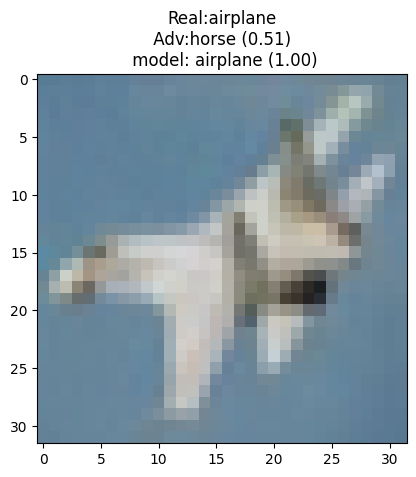

In [170]:
classes=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
to_viz=10
plot_title = f"Real:{classes[all_real_labels[to_viz]]}\n Adv:{classes[all_adversarial_labels[to_viz]]} ({all_adversarial_confidence_labels[to_viz]:.2f}) \n model: {classes[all_model_labels[to_viz]]} ({all_confidence_labels[to_viz]:.2f})"
plt.imshow(all_adversarial_examples[to_viz].numpy().transpose((1,2,0)))
plt.title(plot_title)
plt.show()

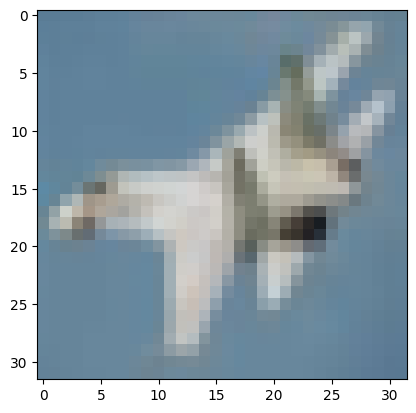

In [171]:

plt.imshow(denormalize(images[to_viz]).numpy().transpose((1,2,0)))
#plt.title("Adv:"+classes[images[to_viz]]+"\n Real:"+classes[all_real_labels[to_viz]])
plt.show()

# Testing Carlini L2

In [172]:
attacks_list["CarliniL2"]


{
    'module': 'art.attacks.evasion',
    'class': 'CarliniL2Method',
    'kwargs': {
        'confidence': 0.0,
        'targeted': False,
        'learning_rate': 0.01,
        'binary_search_steps': 5,
        'max_iter': 10,
        'initial_const': 0.01,
        'max_halving': 5,
        'max_doubling': 5,
        'batch_size': 128,
        'verbose': True
    }
}

In [8]:
Carlini_attack={
    'module': 'art.attacks.evasion',
    'class': 'CarliniL2Method',
    'kwargs': {
        'confidence': 1,
        'targeted': False,
        'learning_rate': 0.01,
        'binary_search_steps': 5,
        'max_iter': 10,
        'initial_const': 0.01,
        'max_halving': 5,
        'max_doubling': 5,
        'batch_size': 128,
        'verbose': True
    }
}

In [9]:
resnet_model = catalog.load("Resnet_model")
classifier = classification(resnet_model)
attack = Evasion_Attack(classifier,attack=Carlini_attack)

[09/20/23 08:37:39] INFO     Loading data from 'Resnet_model' (PytorchDatasetModel)...          ]8;id=162693;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=978217;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\

In [10]:
testloader = Create_data_loader(batch_size=512)
real_labels = []
model_labels = []
adversarial_examples = []
adversarial_labels = []
label_confidence = []
adv_label_confidence = []
for data in testloader:
    images, labels = data
    images_cpu = images.cpu().detach().numpy()
    x_test_adv = attack.generate(x=images_cpu,y=labels.cpu().numpy())
    with torch.no_grad():
        # perform inference
        label_prob = classifier.predict(images_cpu)
        adv_label_prob = classifier.predict(x_test_adv)
        
        # get confidence and labels for real data
        predictions = np.argmax(label_prob,axis=1)
        confidence_predictions = np.max(F.softmax(torch.tensor(label_prob),dim=1).cpu().numpy(),axis=1)
        
        # get confidence and labels for adversarial data
        adversarial_predictions = np.argmax(adv_label_prob,axis=1)
        confidence_predictions_adv = np.max(F.softmax(torch.tensor(adv_label_prob),dim=1).cpu().numpy(),axis=1)

            
        
    adversarial_denorm = [denormalize(torch.tensor(x)) for x in x_test_adv]
    
    
    label_confidence.extend(confidence_predictions)
    adv_label_confidence.extend(confidence_predictions_adv)
    adversarial_examples.extend(adversarial_denorm)
    real_labels.extend(labels.cpu().numpy())
    model_labels.extend(predictions)
    adversarial_labels.extend(adversarial_predictions)
    break
    
    
all_adversarial_examples = torch.stack(adversarial_examples)
all_real_labels = torch.tensor(real_labels)
all_model_labels = torch.tensor(model_labels)
all_adversarial_labels = torch.tensor(adversarial_labels)
all_confidence_labels = torch.tensor(label_confidence)
all_adversarial_confidence_labels = torch.tensor(adv_label_confidence)

adversarial_data = {
    "examples": all_adversarial_examples,
    "confidence": all_confidence_labels,
    "adversarial_confidence": all_adversarial_confidence_labels,
    "real_labels": all_real_labels,
    "model_labels": all_model_labels,
    "adversarial_labels": all_adversarial_labels,
}
old_accuracy = (all_real_labels == all_model_labels).sum().item()/ all_real_labels.size(0)
new_accuracy =  (all_real_labels == all_adversarial_labels).sum().item()/ all_real_labels.size(0)
print(f"Accuracy of the model was {old_accuracy*100:.2f}% and now is {new_accuracy*100:.2f}%")

Files already downloaded and verified


C&W L_2:   0%|          | 0/4 [00:00<?, ?it/s]

Accuracy of the model was 84.18% and now is 63.48%


In [11]:
np.where(all_adversarial_confidence_labels>all_confidence_labels)


(
    array([ 12,  20,  24,  33,  37,  52,  53,  57,  61,  63,  66,  78,  95,
       125, 153, 158, 168, 174, 178, 184, 187, 193, 195, 220, 224, 225,
       233, 249, 255, 256, 264, 271, 310, 319, 332, 368, 383, 405, 411,
       453, 456, 464, 477, 483, 491]),
)

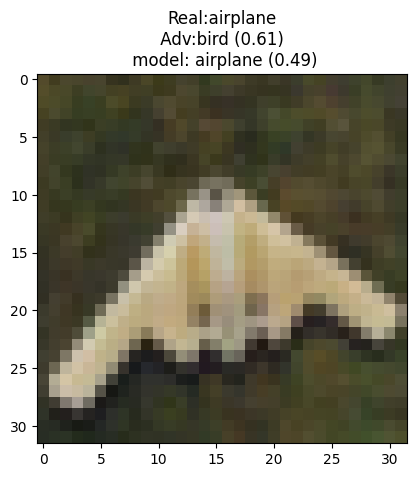

In [14]:
classes=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
to_viz=52
plot_title = f"Real:{classes[all_real_labels[to_viz]]}\n Adv:{classes[all_adversarial_labels[to_viz]]} ({all_adversarial_confidence_labels[to_viz]:.2f}) \n model: {classes[all_model_labels[to_viz]]} ({all_confidence_labels[to_viz]:.2f})"
plt.imshow(all_adversarial_examples[to_viz].numpy().transpose((1,2,0)))
plt.title(plot_title)
plt.show()

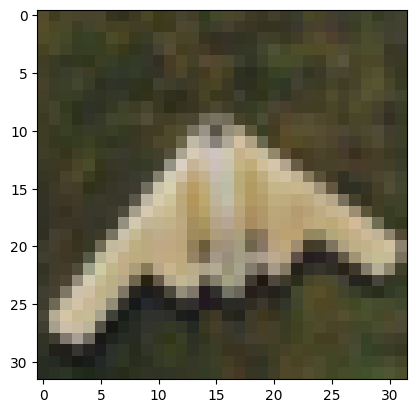

In [16]:
plt.imshow(denormalize(images[to_viz]).numpy().transpose((1,2,0)))
#plt.title("Adv:"+classes[images[to_viz]]+"\n Real:"+classes[all_real_labels[to_viz]])
plt.show()

In [18]:
x="""
C&W L_2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [06:37<00:00, 198.87s/it]
C&W L_2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [06:34<00:00, 197.41s/it]
C&W L_2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [06:33<00:00, 196.85s/it]
C&W L_2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [06:33<00:00, 196.97s/it]
C&W L_2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [06:33<00:00, 196.65s/it]
C&W L_2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [06:33<00:00, 196.79s/it]
C&W L_2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [06:33<00:00, 196.76s/it]
C&W L_2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [06:34<00:00, 197.08s/it]
C&W L_2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [06:33<00:00, 196.80s/it]
C&W L_2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [06:34<00:00, 197.10s/it]
C&W L_2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [06:34<00:00, 197.05s/it]
C&W L_2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [06:34<00:00, 197.05s/it]
C&W L_2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [06:34<00:00, 197.13s/it]
C&W L_2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [06:35<00:00, 197.59s/it]
C&W L_2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [06:34<00:00, 197.29s/it]
C&W L_2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [06:35<00:00, 197.60s/it]
C&W L_2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [06:34<00:00, 197.21s/it]
C&W L_2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [06:35<00:00, 197.87s/it]
C&W L_2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [06:35<00:00, 197.87s/it]
C&W L_2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [03:54<00:00, 117.25s/it]
"""

In [20]:
x.count("\n")

21

# Testing Projected Gradient Descend

In [25]:
attacks_list["PGD"]


{
    'module': 'art.attacks.evasion',
    'class': 'ProjectedGradientDescent',
    'kwargs': {
        'eps': 0.01,
        'eps_step': 0.005,
        'max_iter': 10,
        'batch_size': 256,
        'num_random_init': 1
    }
}

In [ ]:
pgd_attack={
    'module': 'art.attacks.evasion',
    'class': 'ProjectedGradientDescent',
    'kwargs': {
        'eps': 0.01,
        'eps_step': 0.005,
        'max_iter': 10,
        'batch_size': 128,
        'num_random_init': 1
    }
}

resnet_model = catalog.load("Resnet_model")
classifier = classification(resnet_model)
attack = Evasion_Attack(classifier,attack=pgd_attack)